In [1]:
# Libraries for this notebook
import numpy as np
import matplotlib.pyplot as plt


The Hodgkin Huxley model for current has the following form (from TCN equation 5.25). The gating variable $n$ represents the probability that one of the 4 gates in the "delayed rectified" K^+ channels are open, and the $m$ and $h$ gating variables correspond to the opening and activation/inactivation probabilities for the transient Na^+ channels. The gating variables are voltage-dependent, which means we need a dynamic simulation.

$$i_m = \bar{g}_L (V - E_L) + \bar{g}_K n^4 (V - E_K) + \bar{g}_{Na} m^3 h (V - E_{Na})$$

In [2]:
# HH gating variables from TCN Ch 5

# potassium gating variables
a_n = lambda V: 0.01 * (V + 55) / (1 - np.exp(-0.1 * (V + 55)))
B_n = lambda V: 0.125 * np.exp(-0.0125 * (V + 65))
n_inf = lambda V: 1 / (1 + B_n(V)/a_n(V))
t_n = lambda V: 1/a_n(V) / (1 + B_n(V)/a_n(V))

# sodium gating variables
a_m = lambda V :  0.1 * (V + 40) / (1 - np.exp(-0.1 * (V + 40)))
B_m = lambda V: 4 * np.exp(-0.0556 * (V + 65))
m_inf = lambda V: 1 / (1 + B_m(V)/a_m(V))
t_m = lambda V: 1/a_m(V) / (1 + B_m(V)/a_m(V))

a_h = lambda V: 0.07 * np.exp(-0.05 * (V + 65))
B_h = lambda V: 1 / (1 + np.exp(-0.1 * (V + 35)))
h_inf = lambda V: 1 / (1 + B_h(V)/a_h(V))
t_h = lambda V: 1/a_h(V) / (1 + B_h(V)/a_h(V))


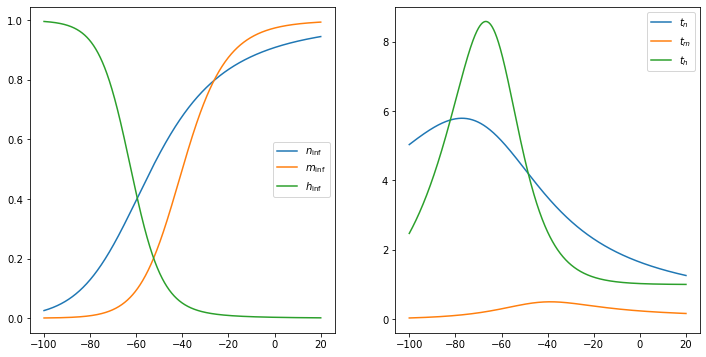

In [3]:
v = np.linspace(-100, 20, 1000)

# Plot gating variables as a function of voltage (TCN Figure 5.10)

fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(v, n_inf(v), label=r'$n_{\inf}$')
ax[0].plot(v, m_inf(v), label=r'$m_{\inf}$')
ax[0].plot(v, h_inf(v), label=r'$h_{\inf}$')
ax[0].legend()
ax[1].plot(v, t_n(v), label=r'$t_n$')
ax[1].plot(v, t_m(v), label=r'$t_m$')
ax[1].plot(v, t_h(v), label=r'$t_h$')
ax[1].legend()

In [22]:
# HH-Neuron Constants from TCN Ch 5
gL = 0.003 # mS / mm2
gK = 0.36
gNa = 1.2
EL = -54.387 # mV
EK = -77
ENa = 50

# cm is usually given as 10 nF/mm2
cm = 0.01
A = 1 # unit area for current injection


In [23]:
# Simulation parameters
T = 200 # 100 ms
dt = 0.01 # 0.01 ms dT

t_vec = np.arange(0, T, dt)
V = np.zeros(len(t_vec))
n = np.zeros(len(t_vec))
m = np.zeros(len(t_vec))
h = np.zeros(len(t_vec))

# Set initial conditions
V[0] = -65
n[0] = n_inf(V[0])
m[0] = m_inf(V[0])
h[0] = h_inf(V[0])

# Define stimulus
def I(t):
#     if (t > 20) and (t < 55): 
#         return 0.25
    if (t > 20) and (t < 90): 
        return 0.25
    elif (t > 100) and (t < 102): 
        return 0.25   
    else:
        return 0


# Simulate as described in Appendix A and B of TCN Ch. 5
for i, t in enumerate(t_vec[:-1]):
    n[i+1] = n_inf(V[i]) + (n[i] - n_inf(V[i])) * np.exp(-dt/t_n(V[i]))
    m[i+1] = m_inf(V[i]) + (m[i] - m_inf(V[i])) * np.exp(-dt/t_m(V[i]))
    h[i+1] = h_inf(V[i]) + (h[i] - h_inf(V[i])) * np.exp(-dt/t_h(V[i]))
    
    scaling = gL + gK*n[i+1]**4 + gNa*m[i+1]**3 * h[i+1]
    V_inf = 1/scaling * (gL*EL + gK*EK * n[i+1]**4 + gNa*ENa * m[i+1]**3 * h[i+1] + I(t)/A)
    t_V = cm/scaling
    V[i+1] = V_inf + (V[i] - V_inf)* np.exp(-dt/t_V)


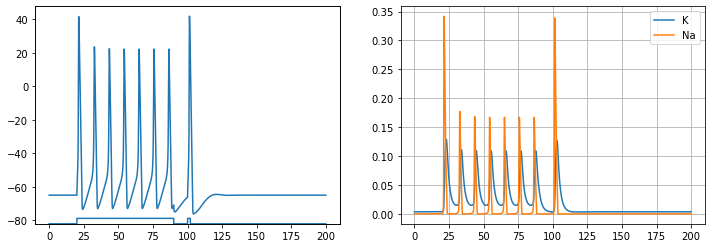

In [24]:
# Plot simulation results
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(t_vec, V)

# Plot stimulus underneath
i_ax = ax[0].twinx()
I_vec = [I(t) for t in t_vec]
i_ax.plot(t_vec, I_vec)
i_ax.set_ylim((0,10))
i_ax.set_yticks([])

# Plot conductances for potasium and sodium
ax[1].plot(t_vec, gK*n**4, label='K')
ax[1].plot(t_vec, gNa*m**3*h, label='Na')
ax[1].legend()
ax[1].grid('major')
